#Stock Price Forecasting using LSTM,ARIMA,SARIMAX

Stock Price Prediction using LSTM 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
# Download stock data
ticketSymbol = 'MSFT'
ticketData = yf.Ticker(ticketSymbol)
ticketDF = ticketData.history(period='1d', start='2014-06-01', end='2024-06-01')

In [2]:
ticketDF.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-02 00:00:00-04:00,34.858413,34.977586,34.628576,34.722214,18504300,0.0,0.0
2014-06-03 00:00:00-04:00,34.560476,34.628577,34.262542,34.296593,18068900,0.0,0.0


In [3]:
ticketDF.to_csv('MSFT_dataset')

In [4]:
# Use only the 'Close' column for prediction
ticketDF = ticketDF[['Close']]

In [5]:
ticketDF.shape

(2518, 1)

In [6]:
ticketDF.head(2)

,Close
Date,
2014-06-02 00:00:00-04:00,34.722214
2014-06-03 00:00:00-04:00,34.296593


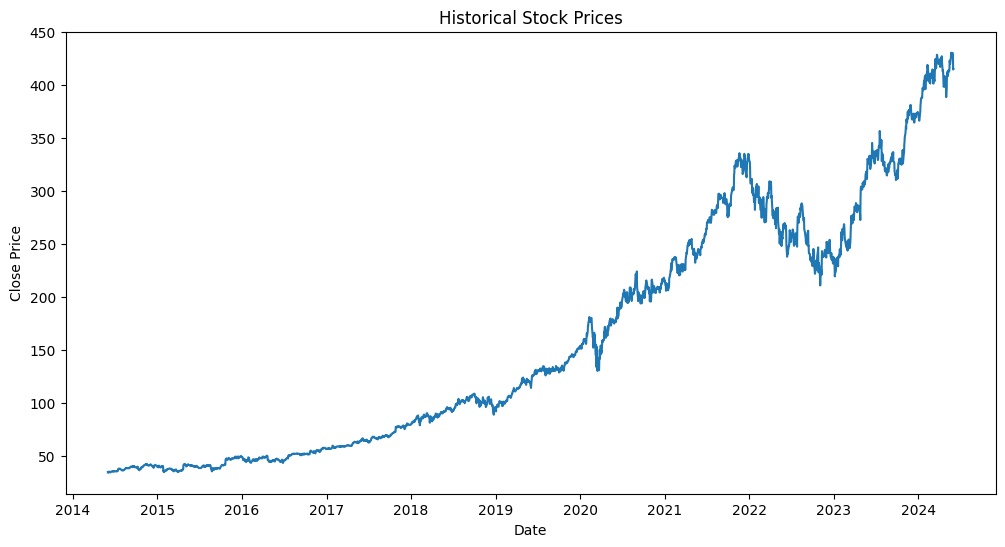

In [7]:
# Plot the historical closing prices
plt.figure(figsize=(12, 6))
plt.plot(ticketDF.index, ticketDF['Close'])
plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [8]:
# Extract closing prices
closing_prices = ticketDF['Close'].values

In [9]:
# Create sequences and labels function
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
# Parameters
seq_length = 50  # Adjust the sequence length as needed

# Create sequences from closing prices
X, y = create_sequences(closing_prices, seq_length)

In [11]:
X

array([[ 34.72221375,  34.29659271,  34.32212448, ...,  36.79924774,
         36.77371979,  36.77371979],
       [ 34.29659271,  34.32212448,  35.07973862, ...,  36.77371979,
         36.77371979,  37.04611206],
       [ 34.32212448,  35.07973862,  35.30957413, ...,  36.77371979,
         37.04611206,  37.52281189],
       ...,
       [416.56863403, 420.65127563, 424.46438599, ..., 427.        ,
        430.16000366, 430.32000732],
       [420.65127563, 424.46438599, 428.59692383, ..., 430.16000366,
        430.32000732, 429.17001343],
       [424.46438599, 428.59692383, 427.9680481 , ..., 430.32000732,
        429.17001343, 414.67001343]])

In [12]:
X.shape

(2468, 50)

In [13]:
# Split data into training, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

In [14]:
train_size

1727

In [15]:
val_size

246

In [16]:
test_size

495

In [17]:
X_train.shape

(1727, 50)

In [18]:
# Fit scaler for features (X) on training data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

In [19]:
# Fit scaler for targets (y) on training data
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [20]:
# Reshape input data to fit LSTM requirements: [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))#no.of batches per epoch=total_no_rows/batch_size

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0191 - val_loss: 0.0091
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1273e-04 - val_loss: 0.0029
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.4037e-04 - val_loss: 0.0043
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.8281e-04 - val_loss: 0.0028
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3690e-04 - val_loss: 0.0022
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9622e-04 - val_loss: 0.0029
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1114e-04 - val_loss: 0.0029
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4913e-04 - val_loss: 0.0028
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.0337e-04 - val_loss: 0.0027
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2017e-04 - val_loss: 0.0026
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5704e-04 - val_loss: 0.0018
Epoch 12/200

In [23]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test_scaled)# per batch average loss
print(f'Test Loss: {loss}')# final loss on entire test

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5456e-04
Test Loss: 0.0011584069579839706


In [24]:
# Make predictions
y_pred_test_scaled = model.predict(X_test_scaled)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [26]:
# Inverse transform the predictions and actual values
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

In [27]:
pd.DataFrame({'Actual_test':y_test.ravel(),'Predicted_test':y_pred_test.ravel()})

,Actual_test,Predicted_test
0,238.078262,250.261429
1,240.269775,239.854111
2,247.414276,241.389572
3,240.741486,248.872589
4,243.375229,243.630112
...,...,...
490,430.160004,413.735382
491,430.320007,417.788452
492,429.170013,417.149414
493,414.670013,415.611572


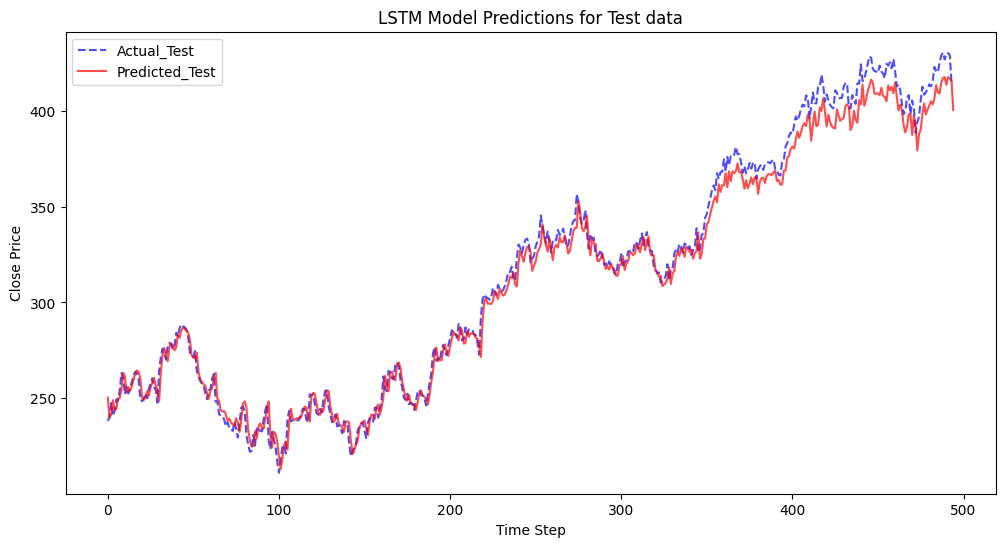

In [28]:
# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual_Test', color='blue', linestyle='--', alpha=0.7)
plt.plot(y_pred_test, label='Predicted_Test', color='red', linestyle='-', alpha=0.7)
plt.title('LSTM Model Predictions for Test data')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

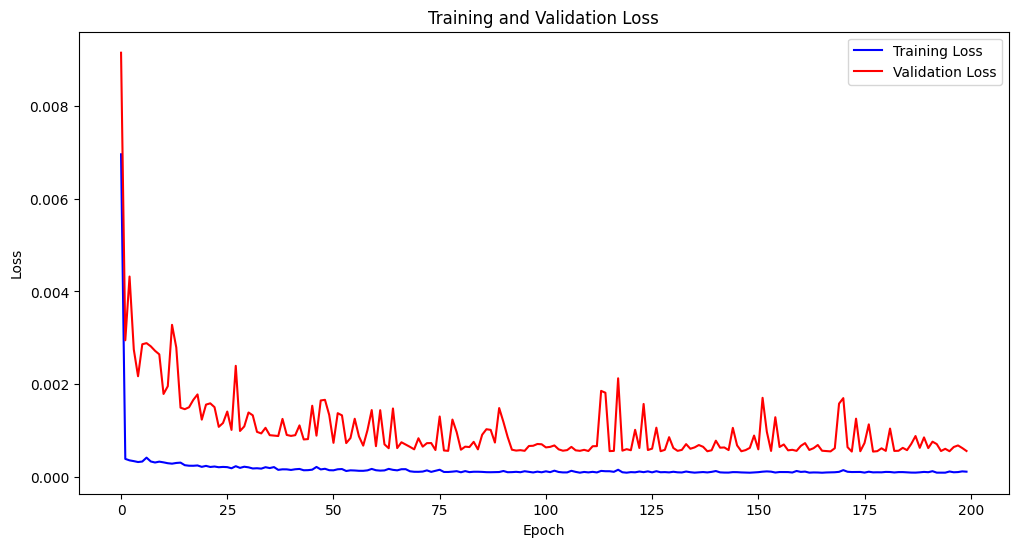

In [29]:
# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# Compute Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error for Test: {mae}')
y_train=scaler_y.inverse_transform(y_train_scaled)
# X_train=scaler_X.inverse_transform(X_train_scaled)

y_pred_train=model.predict(X_train_scaled)
y_pred_train=scaler_y.inverse_transform(y_pred_train)
print(f'Mean Absolute Error for Train :{mean_absolute_error(y_train,y_pred_train)}')

Mean Absolute Error for Test: 5.8800484705452964
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Absolute Error for Train :1.2512165460547895


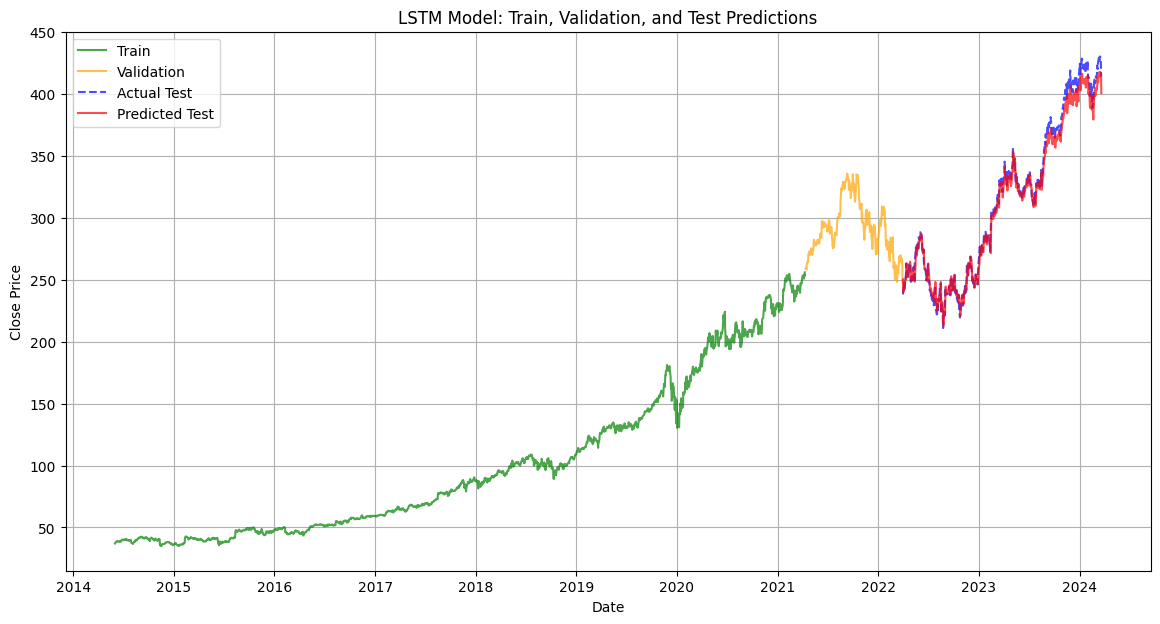

In [44]:
import matplotlib.pyplot as plt

# Indices for plotting
train_idx = ticketDF.index[:len(y_train)]
val_idx = ticketDF.index[len(y_train):len(y_train) + len(y_val)]
test_idx = ticketDF.index[len(y_train) + len(y_val):len(y_train) + len(y_val) + len(y_test)]

# Plot the entire data with train, validation, and test sets including predictions
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_idx, y_train, label='Train', color='green', linestyle='-', alpha=0.7)

# Plot validation data
plt.plot(val_idx, y_val, label='Validation', color='orange', linestyle='-', alpha=0.7)

# Plot actual test data
plt.plot(test_idx, y_test, label='Actual Test', color='blue', linestyle='--', alpha=0.7)

# Plot predictions for test data
plt.plot(test_idx, y_pred_test, label='Predicted Test', color='red', linestyle='-', alpha=0.7)

plt.title('LSTM Model: Train, Validation, and Test Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Time Series Forecasting using ARIMA

In [57]:
import yfinance as yf
ticketSymbol = 'MSFT'
ticketData = yf.Ticker(ticketSymbol)
ticketDF = ticketData.history(period='1d', start='2014-06-01', end='2024-06-01')
# Use only the 'Close' column for prediction
ticketDF = ticketDF[['Close']]
ticketDF.head(2)

,Close
Date,
2014-06-02 00:00:00-04:00,34.722214
2014-06-03 00:00:00-04:00,34.296593


In [58]:
ticketDF.shape

(2518, 1)

c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model fitting time: 0.46 seconds
Mean Absolute Error (MAE): 69.88
Mean Squared Error (MSE): 8213.25


c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


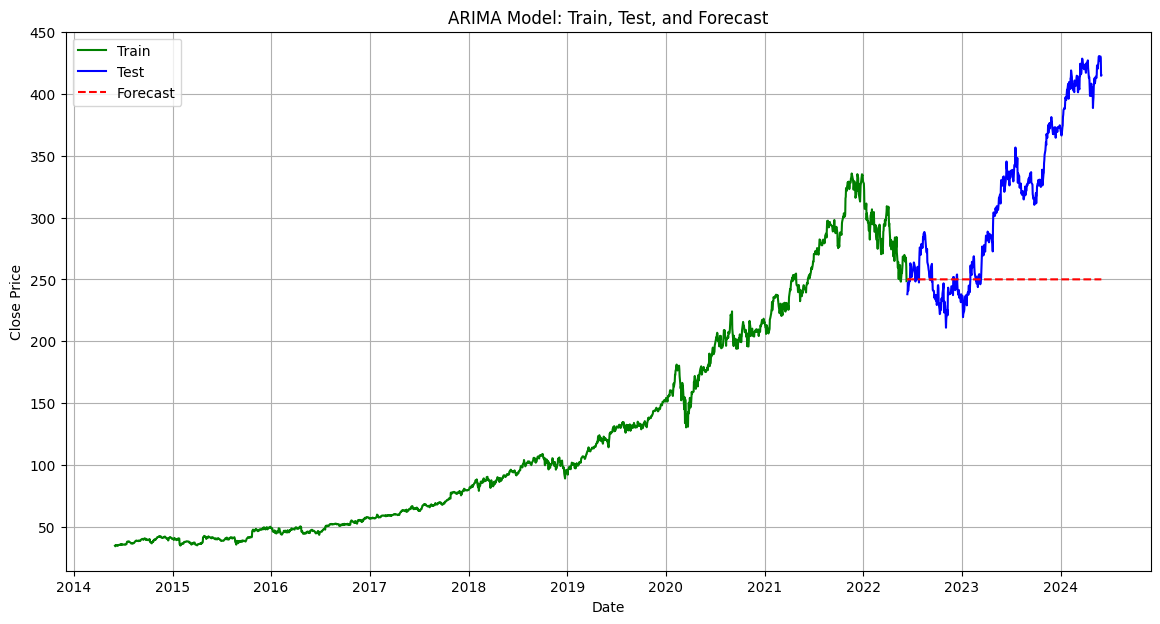

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

# Ensure the 'Date' column is timezone-naive
ticketDF.index = ticketDF.index.tz_localize(None)

# Prepare the data for ARIMA
df = ticketDF.reset_index()
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Rename columns
df.set_index('ds', inplace=True)  # Set 'ds' as the index

# Define test size
test_size = 495

# Split data into training and testing sets
train_size = len(df) - test_size
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define and fit the ARIMA model
model = ARIMA(train['y'], order=(1, 1, 1))  # ARIMA(p, d, q) parameters

start_time = time.time()
results = model.fit()
end_time = time.time()

print(f"Model fitting time: {end_time - start_time:.2f} seconds")

# Forecast future values
forecast = results.get_forecast(steps=len(test))

# Use the forecast's index to match the test data's index
forecast_index = test.index

# Prepare forecast data
forecasted_values = pd.DataFrame({
    'ds': forecast_index,  # Correct index from the test set
    'Forecast': forecast.predicted_mean.values
})

# Reset index in actual values for merging
actual_values = test.reset_index()

# Merge actual and forecasted values for comparison
comparison_df = pd.merge(actual_values, forecasted_values, on='ds', how='inner')

# Calculate and print performance metrics
mae = mean_absolute_error(comparison_df['y'], comparison_df['Forecast'])
mse = mean_squared_error(comparison_df['y'], comparison_df['Forecast'])
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Plot the actual vs. forecasted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train['y'], label='Train', color='green')

# Plot actual test data
plt.plot(test.index, test['y'], label='Test', color='blue')

# Plot forecasted values
plt.plot(comparison_df['ds'], comparison_df['Forecast'], label='Forecast', color='red', linestyle='dashed')

plt.title('ARIMA Model: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: 1.412768840681964
p-value: 0.9971713836795458


In [66]:
#Time series is non-stationary usig arima

Stock Price Forecasting using SARIMAX

c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Model fitting time: 37.68 seconds
Mean Absolute Error (MAE) on test data: 49.67820065580143
Mean Squared Error (MSE) on test data: 3916.250895835465


c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\kamma\OneDrive\Documents\python23\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


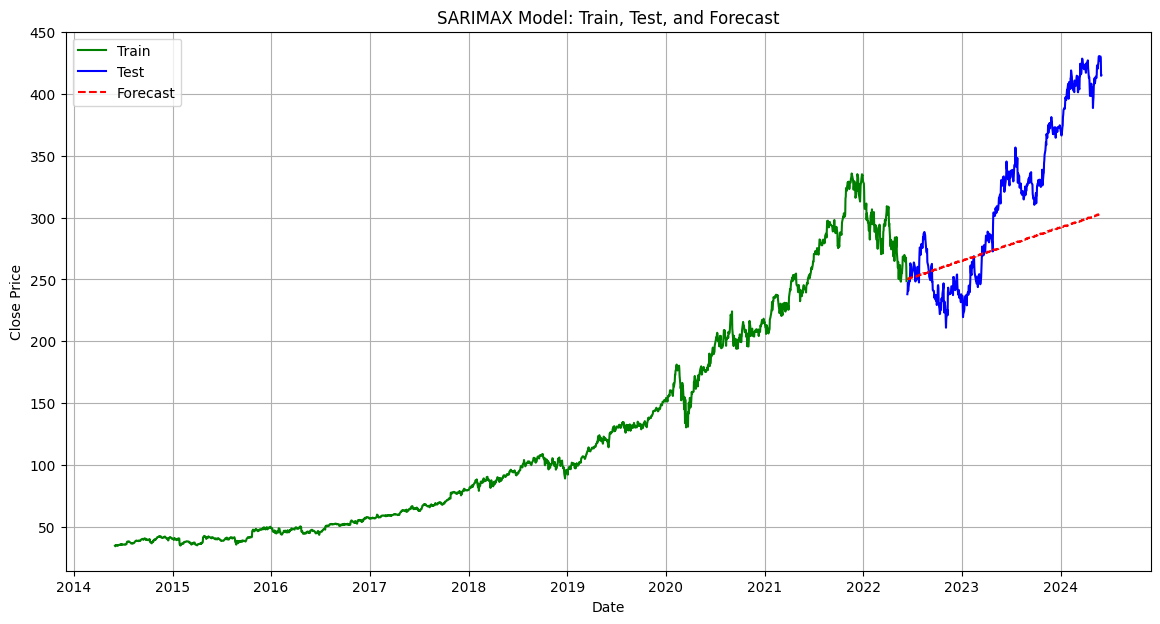

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import time

# Download stock data
ticketSymbol = 'MSFT'
ticketData = yf.Ticker(ticketSymbol)
ticketDF = ticketData.history(period='1d', start='2014-06-01', end='2024-06-01')

# Use only the 'Close' column for prediction
ticketDF = ticketDF[['Close']]

# Ensure the 'Date' column is timezone-naive
ticketDF.index = ticketDF.index.tz_localize(None)

# Prepare the data for SARIMAX
df = ticketDF.reset_index()
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)  # Rename columns
df.set_index('ds', inplace=True)  # Set 'ds' as the index

# Specify the number of test points
test_size = 495

# Split data into training and testing sets
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

# Set seasonal order based on observed seasonality (e.g., monthly)
seasonal_order = (1, 1, 1, 30)  # (P, D, Q, s)

# Define SARIMAX model
sarimax_model = SARIMAX(
    train['y'],
    order=(1, 1, 1),  # (p, d, q) for the non-seasonal part
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# Fit the model
start_time = time.time()
sarimax_results = sarimax_model.fit()
end_time = time.time()

print(f"Model fitting time: {end_time - start_time:.2f} seconds")

# Compute forecast for the test period
forecast_sarimax = sarimax_results.get_forecast(steps=len(test))

# Extract forecasted mean and use the correct date index
forecasted_values_sarimax = pd.DataFrame({
    'ds': test.index,  # Use the correct datetime index
    'Forecast': forecast_sarimax.predicted_mean.values
})

# Ensure dates are in datetime format (optional, but ensures consistency)
forecasted_values_sarimax['ds'] = pd.to_datetime(forecasted_values_sarimax['ds'])

# Merge forecasted values with the actual test set
comparison_df_sarimax = pd.merge(test.reset_index(), forecasted_values_sarimax, on='ds', how='inner').dropna()

# Calculate MAE and MSE
mae_sarimax = mean_absolute_error(comparison_df_sarimax['y'], comparison_df_sarimax['Forecast'])
mse_sarimax = mean_squared_error(comparison_df_sarimax['y'], comparison_df_sarimax['Forecast'])

print(f'Mean Absolute Error (MAE) on test data: {mae_sarimax}')
print(f'Mean Squared Error (MSE) on test data: {mse_sarimax}')

# Plot the results
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train.index, train['y'], label='Train', color='green')

# Plot actual test data
plt.plot(test.index, test['y'], label='Test', color='blue')

# Plot forecasted values
plt.plot(comparison_df_sarimax['ds'], comparison_df_sarimax['Forecast'], label='Forecast', color='red', linestyle='dashed')

plt.title('SARIMAX Model: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
